In [22]:
import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image

In [23]:
import os

file_names = os.listdir('./data/img_align_celeba')
img_paths = ['./data/img_align_celeba/' + file_name for file_name in file_names]
len(img_paths)

70560

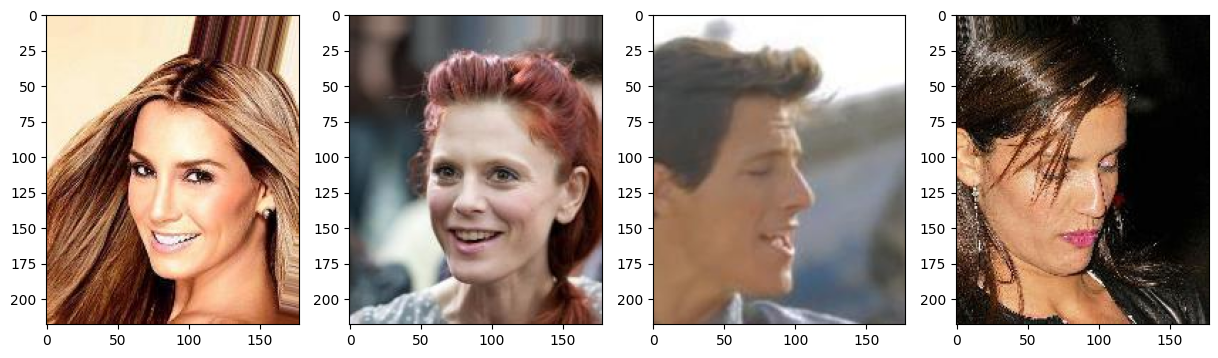

In [24]:
import matplotlib.pyplot as plt

def show_images(file_names, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(file_names):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_np)

def show_masked_images(img_with_mask, num_samples=4, cols=4):
    # Nếu tensor đang ở GPU, chuyển về CPU
    if img_with_mask.is_cuda:
        img_with_mask = img_with_mask.cpu()
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, 15))
    for i, img in enumerate(img_with_mask):
        # Unnormalize ảnh: với normalization (img - 0.5)/0.5, ta thực hiện: img*0.5 + 0.5
        img = img * 0.5 + 0.5
        # Chuyển đổi tensor từ (C, H, W) sang (H, W, C) để hiển thị bằng matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
    plt.show()
show_images(img_paths)

## Create data loader

In [25]:
num_train, num_val = 1000, 100  # demo with small data
train_imgpaths = img_paths[: num_train]
val_imgpaths = img_paths[num_train: num_train + num_val]

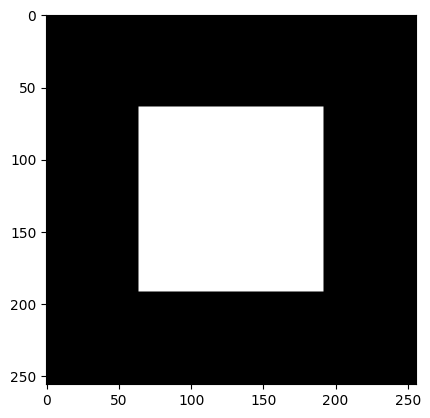

In [26]:
def bbox2mask(img_shape, bbox):
    """
    img_shape: (h, w, c)
    bbox: (x1, y1, w, h)
    """
    h_img, w_img = img_shape
    x1, y1, w, h = bbox
    mask = np.zeros((h_img, w_img), dtype=np.uint8)
    mask[y1:y1 + h, x1:x1 + w] = 1
    return mask


test_mask = bbox2mask((256, 256), (256//4, 256//4, 256//2, 256//2))
plt.imshow(test_mask, cmap='gray')

In [27]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class InpaintingDataset():
    def __init__(self, img_paths, mask_mode, data_len=100, image_size=[256, 256]):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths

        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.mask_mode = mask_mode
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        img_with_mask = torch.where(mask[0] == 0, img, torch.tensor( # mask[0] : [h, w] broadcast-> [3, h, w] where with-> [3, h, w]
            0, dtype=img.dtype, device=img.device))
        
        return img_with_mask, mask

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        if self.mask_mode == 'center':
            h, w = self.image_size
            mask = bbox2mask(self.image_size, (h//4, w//4, h//2, w//2))
        else:
            raise NotImplementedError(
                f'Mask mode {self.mask_mode} has not been implemented.')
        return torch.from_numpy(mask).unsqueeze(0)

In [28]:
from torch.utils.data import DataLoader
train_dataset = InpaintingDataset(train_imgpaths, mask_mode='center')
val_dataset = InpaintingDataset(val_imgpaths, mask_mode='center')

BATCH_SIZE = 4
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Shape của img_with_mask: torch.Size([4, 3, 256, 256])
Shape của mask: torch.Size([1, 256, 256])


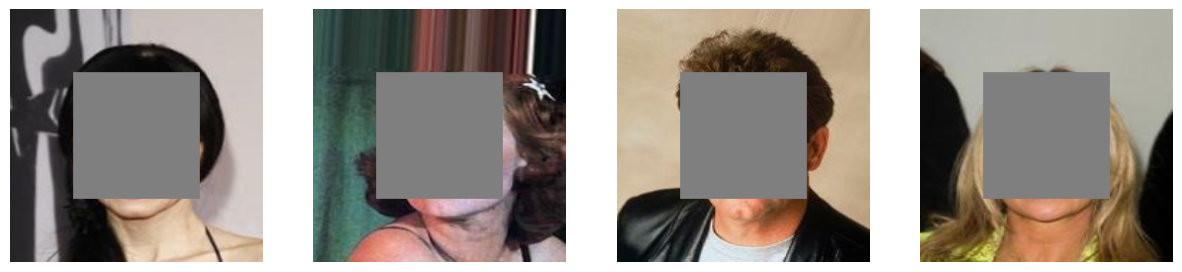

In [29]:
# Lấy iterator từ train_loader
data_iter = iter(train_loader)

# Lấy một batch (img_with_mask, mask) từ iterator
img_with_mask, mask = next(data_iter)

# In ra kích thước của các tensor để kiểm tra
print("Shape của img_with_mask:", img_with_mask.shape)
print("Shape của mask:", mask[0].shape)

# Hiển thị ảnh với mask
show_masked_images(img_with_mask, num_samples=4, cols=4)

## Model

In [30]:
from torch import nn
import math
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, up = False):
        super(Block, self).__init__()
        self.time_emb_proj = nn.Linear(time_emb_dim, out_channels)
        if up:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
            self.transform = nn.Conv2d(
                out_channels, out_channels, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, t):
        x = self.relu(self.bn1(self.conv1(x)))
        t = self.relu(self.time_emb_proj(t))
        t = t.unsqueeze(2).unsqueeze(2) # (B, C) -> (B, C, 1, 1)
        t = t.expand(-1, -1, x.shape[2], x.shape[3]) # (B, C, 1, 1) -> (B, C, H, W)
        x = x + t
        x = self.relu(self.bn2(self.conv3(x)))

        # up or downsampling
        x = self.transform(x)
        return x
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time_emb):
        device = time_emb.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = torch.tensor(time_emb).unsqueeze(
            1) * embeddings.unsqueeze(0) # (B, 1) * (1, half_dim) -> (B, half_dim) : scalar * vector
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        
        return embeddings
    


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Time embedding
        t = self.time_mlp(timestep)

        # Initial projection
        x = self.conv0(x)

        # Downsample
        for down in self.downs:
            x = down(x, t)

        # Upsample
        for up in self.ups:
            x = up(x, t)

        # Output layer
        return self.output(x)
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  51297763


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_emb_proj): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Block(
      (time_emb_proj): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [31]:
x = img_with_mask[0:1]  # Lấy một bức ảnh, shape (1, C, H, W)
x = x.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Tạo bước thời gian (timestep) cho ảnh. Ví dụ, dùng giá trị 10.
timestep = torch.tensor([10.0], device=device)

with torch.no_grad():
    output = model(x, timestep)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20708\3196022626.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(time_emb).unsqueeze(


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])
